In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Paths to your dataset
base_dir = '/kaggle/input/corndata/Corn_Data_SET'

# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32
seed = 123  # Ensure reproducibility
validation_split = 0.2  # 20% of data used for validation

# Load the training dataset
train_generator = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split=validation_split,
    subset="training",
    interpolation="bilinear"
)

# Load the validation dataset
val_generator = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split=validation_split,
    subset="validation",
    interpolation="bilinear"
)

# Load the DenseNet121 model with pre-trained weights, excluding the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers using GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling instead of Flatten
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Calculate the number of layers to unfreeze
total_layers = len(base_model.layers)
unfreeze_layers = int(0.20 * total_layers)  # Unfreeze the last 20% of layers

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 20% of layers
for layer in base_model.layers[-unfreeze_layers:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,  # Increased epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop]
)

# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc:.2f}')



Found 20332 files belonging to 4 classes.
Using 16266 files for training.
Found 20332 files belonging to 4 classes.
Using 4066 files for validation.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


I0000 00:00:1733040923.742473      86 service.cc:145] XLA service 0x78ee0006c2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733040923.742543      86 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/509 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.1632 - loss: 2.1484   

I0000 00:00:1733040960.775968      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


509/509 ━━━━━━━━━━━━━━━━━━━━ 120s 129ms/step - accuracy: 0.2677 - loss: 1.7699 - val_accuracy: 0.4781 - val_loss: 1.2299 - learning_rate: 1.0000e-04
Epoch 2/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.3706 - loss: 1.4618 - val_accuracy: 0.5526 - val_loss: 1.0993 - learning_rate: 1.0000e-04
Epoch 3/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.4196 - loss: 1.3046 - val_accuracy: 0.6208 - val_loss: 0.9778 - learning_rate: 1.0000e-04
Epoch 4/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.4738 - loss: 1.2117 - val_accuracy: 0.6495 - val_loss: 0.9207 - learning_rate: 1.0000e-04
Epoch 5/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.5220 - loss: 1.1270 - val_accuracy: 0.6709 - val_loss: 0.8658 - learning_rate: 1.0000e-04
Epoch 6/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.5522 - loss: 1.0749 - val_accuracy: 0.6943 - val_loss: 0.8102 - learning_rate: 1.0000e-04
Epoch 7/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accur

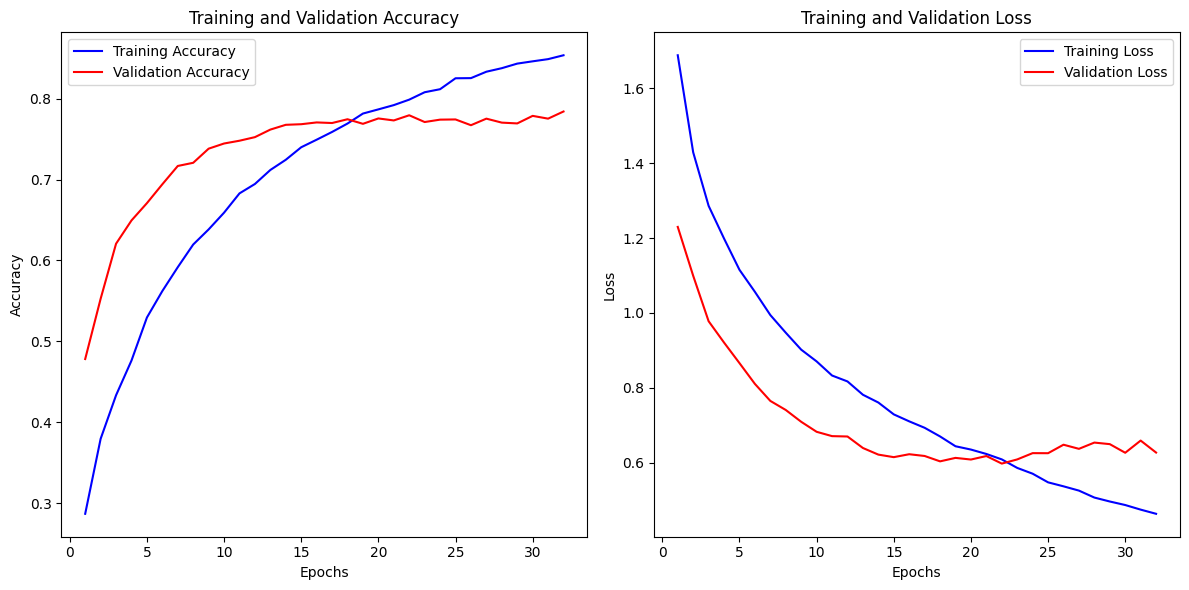

In [2]:
import matplotlib.pyplot as plt

# Get training and validation accuracy from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


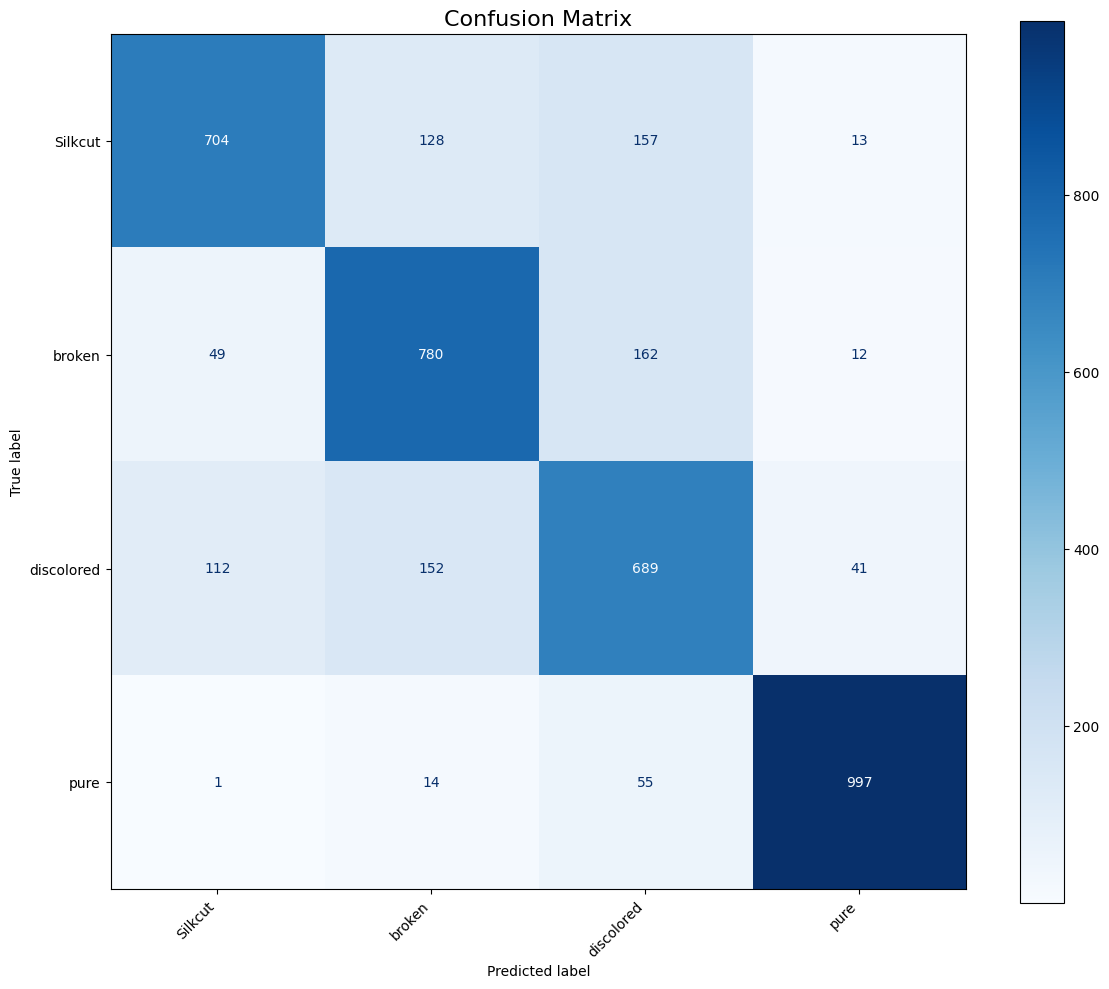

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predicted labels for the validation data
true_labels = []
predicted_labels = []

# Iterate through the validation data to get true and predicted labels
for images, labels in val_generator:
    # True labels
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    
    # Predicted labels
    preds = model.predict(images, verbose=0)
    predicted_labels.extend(np.argmax(preds, axis=1))

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
class_names = val_generator.class_names  # Class names inferred from the dataset
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Create a figure for better layout
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap=plt.cm.Blues, colorbar=True, ax=ax)

# Rotate and align x-axis labels to avoid overlapping
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.tight_layout()  # Automatically adjusts layout for readability
plt.show()


In [4]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predicted labels for the validation data
true_labels = []
predicted_labels = []

# Iterate through the validation data to get true and predicted labels
for images, labels in val_generator:
    # True labels
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    
    # Predicted labels
    preds = model.predict(images, verbose=0)
    predicted_labels.extend(np.argmax(preds, axis=1))

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Class names
class_names = val_generator.class_names  # Inferred from the dataset

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     Silkcut       0.78      0.70      0.75      1002
      broken       0.73      0.78      0.75      1003
  discolored       0.75      0.79      0.77       994
        pure       0.74      0.73      0.74      1067

    accuracy                           0.78      4066
   macro avg       0.78      0.78      0.78      4066
weighted avg       0.78      0.78      0.78      4066

